## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from tqdm import tqdm
import joblib

from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

2022-02-21 21:25:10.384929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-21 21:25:10.384954: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
file_path = "complaints.json"
with open(file_path, 'r') as f:
    data = json.load(f)
    
df = pd.json_normalize(data)

## Data preparation

### Inspect the dataframe to understand the given data.


In [3]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.shape

(78313, 22)

In [5]:
df['_index'].unique(), df['_type'].unique(), df['_id'].unique()

(array(['complaint-public-v2'], dtype=object),
 array(['complaint'], dtype=object),
 array(['3211475', '3229299', '3199379', ..., '3133355', '3110963',
        '2001189'], dtype=object))

In [6]:
only_one_value_cols = []
for column in df:
    if len(df[column].unique()) == 1:
        print(column, ":", df[column].unique())
        only_one_value_cols.append(column)

_index : ['complaint-public-v2']
_type : ['complaint']
_score : [0.]
_source.company : ['JPMORGAN CHASE & CO.']


In [7]:
for column in df:
    if len(df[column].unique()) == 2:
        print(column, ":", df[column].unique())

_source.timely : ['Yes' 'No']


In [8]:
for column in df:
    if len(df[column].unique()) == 3:
        print(column, ":", df[column].unique())

_source.consumer_disputed : ['N/A' 'No' 'Yes']


#### dropping columns with only one type of value

In [9]:
df.drop(columns=only_one_value_cols, inplace=True)

In [10]:
df.head(1)

,_id,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,3211475,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [11]:
df.shape

(78313, 18)

In [12]:
len(df['_id'].unique())

78313

#### dropping id column as all values are different

In [13]:
df.drop('_id', axis=1, inplace=True)

In [14]:
df.head(1)

,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [15]:
df.shape

(78313, 17)

In [16]:
# print the column names
df.columns.to_list()

['_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [17]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
'_source.zip_code':'zip_code',
'_source.complaint_id':'complaint_id',
'_source.issue':'issue',
'_source.date_received':'date_received',
'_source.state':'state',
'_source.consumer_disputed':'consumer_disputed',
'_source.product':'product',
'_source.company_response':'company_response',
'_source.submitted_via':'submitted_via',
'_source.date_sent_to_company':'date_sent_to_company',
'_source.company_public_response':'company_public_response',
'_source.sub_product':'sub_product',
'_source.timely':'timely',
'_source.complaint_what_happened':'complaint_what_happened',
'_source.sub_issue':'sub_issue',
'_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True
)

In [18]:
df.columns.to_list()

['tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [19]:
for column in df:
    if len(df[column].unique()) > 10:
        print(column, ':', len(df[column].unique()))
        # print(column, ":", df[column].unique())

zip_code : 9443
complaint_id : 78313
issue : 154
date_received : 3444
state : 63
product : 17
date_sent_to_company : 3309
sub_product : 73
complaint_what_happened : 20931
sub_issue : 206


In [20]:
df.drop('complaint_id', inplace=True, axis=1)

In [21]:
df.shape

(78313, 16)

In [22]:
df.head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [23]:
print(df.columns.to_list())

['tags', 'zip_code', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [24]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].head(3)

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
Name: complaint_what_happened, dtype: object

In [25]:
df['complaint_what_happened'].str.strip() == ''

0         True
1        False
2        False
3         True
4         True
         ...  
78308     True
78309    False
78310    False
78311    False
78312    False
Name: complaint_what_happened, Length: 78313, dtype: bool

In [26]:
# count tickets with actual complaints
sum(df['complaint_what_happened'].str.strip() == '')

57241

In [27]:
df['complaint_what_happened'].isna().sum()

0

In [28]:
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [29]:
df['complaint_what_happened'].isna().sum()

57241

In [30]:
# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened']).head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [31]:
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [32]:
df['complaint_what_happened'].isna().sum()

0

In [33]:
df.shape

(21072, 16)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [34]:
def preprocess_text(inp):
    # make the text lowercase
    # remove text in square brackets
    # remove punctuation
    # remove words containing numbers
    # remove \n
    inp = inp.lower()
    inp = re.sub("\[.*\]", "", inp).strip()
    inp = re.sub(r'[^\w\s]', '', inp).strip()
    inp = re.sub(r'\w*\d\w*', '', inp).strip()
    inp = re.sub(r'\n', '', inp).strip()
    
    return inp

In [35]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(preprocess_text)

In [36]:
df.reset_index(drop=True, inplace=True)

#### Lemmatize

In [37]:
df['complaint_what_happened'][0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [38]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
x = nlp(df['complaint_what_happened'][0])

In [39]:
# for idx, word in enumerate(x.text.split(" ")):
#     print(idx, ":", word)

In [40]:
x[57], x[57].lemma_

(receiving, 'receive')

In [41]:
lemmatizer = lambda doc: [token.lemma_ for token in doc]

In [42]:
df_clean = pd.DataFrame(df['complaint_what_happened'])

In [43]:
df_clean['complaint_what_happened'][1]

'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [44]:
print(lemmatizer(nlp(df_clean['complaint_what_happened'][1])))

['I', 'upgrade', 'my', 'xxxx', 'xxxx', 'card', 'in', ' ', 'and', 'be', 'tell', 'by', 'the', 'agent', 'who', 'do', 'the', 'upgrade', 'my', 'anniversary', 'date', 'would', 'not', 'change', 'it', 'turn', 'the', 'agent', 'be', 'give', 'I', 'the', 'wrong', 'information', 'in', 'order', 'to', 'upgrade', 'the', 'account', 'xxxx', '  ', 'change', 'my', 'anniversary', 'date', 'from', 'xxxxxxxx', 'to', 'xxxxxxxx', 'without', 'my', 'consent', 'xxxx', 'have', 'the', 'recording', 'of', 'the', 'agent', 'who', 'be', 'mislead', 'I']


In [45]:
def lemmatize_series(series):
    lemmatized_complaints = []
    nlp = en_core_web_sm.load()
    nlp.select_pipes(disable=['ner'])
    for index, doc in enumerate(tqdm(nlp.pipe(series), total=len(series))):
        lemmatized_complaint = lemmatizer(doc)
        lemmatized_complaints.append(" ".join(lemmatized_complaint))
    return lemmatized_complaints
    
lemmatized_complaints = lemmatize_series(df['complaint_what_happened'])

100%|█████████████████████████████████████████████████████████| 21072/21072 [04:35<00:00, 76.40it/s]


In [46]:
len(lemmatized_complaints)

21072

In [47]:
len(df['complaint_what_happened'])

21072

In [48]:
df_clean = pd.DataFrame({"complaint": df['complaint_what_happened'].tolist(), 
                         "lemmatized_complaint": lemmatized_complaints})

In [49]:
df_clean.head()

,complaint,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [52]:
joblib.dump(df_clean, "lemmatized_data.gz")

['lemmatized_data.gz']

---

In [53]:
df_clean = joblib.load("lemmatized_data.gz")

In [54]:
df_clean.head()

,complaint,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [55]:
df_clean['lemmatized_complaint']

0        good morning my name be xxxx xxxx and I apprec...
1        I upgrade my xxxx xxxx card in   and be tell b...
2        chase card be report on   however fraudulent a...
3        on   while try to book a xxxx   xxxx   ticket ...
4        my grand son give I check for   I deposit it i...
                               ...                        
21067    after be a chase card customer for well over a...
21068    on wednesday xxxxxxxx I call chas my xxxx xxxx...
21069    I be not familiar with xxxx pay and do not und...
21070    I have have flawless credit for   yrs I ve hav...
21071    roughly   year ago I close out my account with...
Name: lemmatized_complaint, Length: 21072, dtype: object

In [56]:
# pos tag analysis
# stopword removal

![SpaCy Pipeline](spacy_pipeline.png)

In [57]:
def get_relevant_words_via_pos_tagging(series):
    relevant_words_list = []
    nlp = en_core_web_sm.load()
    nlp.select_pipes(disable=['ner'])
    cnt = 0
    for index, doc in enumerate(tqdm(nlp.pipe(series), total=len(series))):
        relevant_words = []
        for word in doc:
            if "NN" in word.tag_:
                relevant_words.append(word.text)
        relevant_words_list.append(" ".join(relevant_words))
    return relevant_words_list

relevant_words_from_complaints = get_relevant_words_via_pos_tagging(df_clean['lemmatized_complaint'])

100%|█████████████████████████████████████████████████████████| 21072/21072 [04:27<00:00, 78.82it/s]


In [58]:
df_clean['nouns'] = relevant_words_from_complaints

In [59]:
joblib.dump(df_clean, "relevant_words.gz")

['relevant_words.gz']

In [60]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(2)

,complaint,lemmatized_complaint,nouns
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

### Visualising the data 
- according to the 'Complaint' character length

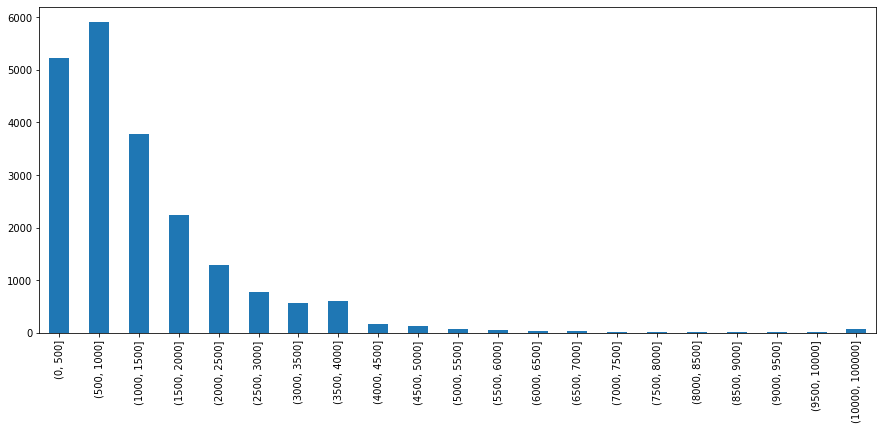

In [63]:
plt.figure(figsize=(15,6))
bins = list(np.arange(0, 10500, 500))
bins.append(100000)
pd.cut(df_clean['complaint'].str.len(), bins=bins).value_counts(sort=False).plot(kind='bar')
plt.show()

#### Observation
- Majority of the complaints are below 4000 characters
- Most common complaint length is 500-1000 characters long

### WordCloug with top 40 words by frequency of occurence

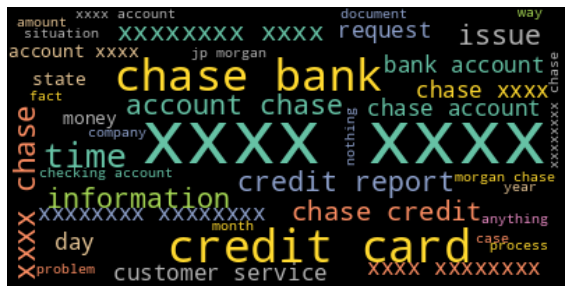

In [65]:
from wordcloud import WordCloud, STOPWORDS
text = " ".join(complaint for complaint in df_clean.nouns)

wordcloud = WordCloud(max_words=40, background_color='black', colormap='Set2', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sameer/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [68]:
text = " ".join(df_clean['nouns'].tolist())
tokens = nltk.word_tokenize(text)

In [69]:
tokens[0:5]

['morning', 'name', 'xxxx', 'stop', 'bank']

#### Top 30 Unigrams

In [70]:
unigrams = ngrams(tokens,1)
unigrams_list = list(Counter(unigrams).most_common(30))

In [71]:
unigrams_list

[(('xxxx',), 134113),
 (('chase',), 72496),
 (('account',), 47706),
 (('credit',), 33485),
 (('card',), 30425),
 (('bank',), 28098),
 (('xxxxxxxx',), 27628),
 (('payment',), 21085),
 (('time',), 15995),
 (('charge',), 14063),
 (('day',), 12899),
 (('money',), 11900),
 (('check',), 11374),
 (('loan',), 10950),
 (('information',), 9624),
 (('letter',), 9602),
 (('call',), 9062),
 (('fee',), 8924),
 (('report',), 8808),
 (('transaction',), 8628),
 (('number',), 8596),
 (('month',), 8443),
 (('amount',), 8403),
 (('year',), 8257),
 (('mortgage',), 8152),
 (('customer',), 8145),
 (('balance',), 7771),
 (('service',), 7715),
 (('phone',), 7610),
 (('company',), 7584)]

#### Top 10 words in unigram by frequency

In [72]:
for word in unigrams_list[0:10]:
    print(word[0][0])

xxxx
chase
account
credit
card
bank
xxxxxxxx
payment
time
charge


#### Top 30 Bigrams
- printing 10 bigrams from top 30

In [73]:
bigrams = ngrams(tokens,2)
bigrams_list = list(Counter(bigrams).most_common(30))
print(bigrams_list)

[(('xxxx', 'xxxx'), 58042), (('credit', 'card'), 12839), (('chase', 'bank'), 12116), (('xxxx', 'chase'), 4680), (('credit', 'report'), 3941), (('account', 'chase'), 3806), (('xxxxxxxx', 'xxxx'), 3380), (('chase', 'credit'), 3348), (('customer', 'service'), 3080), (('xxxx', 'xxxxxxxx'), 2938), (('xxxxxxxx', 'xxxxxxxx'), 2803), (('chase', 'xxxx'), 2767), (('chase', 'account'), 2727), (('bank', 'account'), 2718), (('account', 'xxxx'), 2707), (('checking', 'account'), 2606), (('jp', 'morgan'), 2465), (('morgan', 'chase'), 2463), (('xxxxxxxx', 'chase'), 2226), (('xxxx', 'account'), 2224), (('debit', 'card'), 2022), (('account', 'account'), 1959), (('card', 'chase'), 1873), (('chase', 'card'), 1722), (('bank', 'xxxx'), 1710), (('credit', 'score'), 1707), (('number', 'xxxx'), 1659), (('phone', 'call'), 1639), (('xxxx', 'credit'), 1592), (('card', 'account'), 1569)]


In [74]:
for word in bigrams_list[0:10]:
    print(word[0][0], "|", word[0][1])

xxxx | xxxx
credit | card
chase | bank
xxxx | chase
credit | report
account | chase
xxxxxxxx | xxxx
chase | credit
customer | service
xxxx | xxxxxxxx


#### Top 30 Trigrams
- printing 10 Trigrams from top 30

In [75]:
trigrams = ngrams(tokens,3)
trigrams_list = list(Counter(trigrams).most_common(30))
print(trigrams_list)

[(('xxxx', 'xxxx', 'xxxx'), 29176), (('chase', 'credit', 'card'), 2356), (('jp', 'morgan', 'chase'), 2080), (('xxxx', 'xxxx', 'chase'), 1741), (('xxxxxxxx', 'xxxx', 'xxxx'), 1549), (('xxxx', 'xxxx', 'xxxxxxxx'), 1280), (('credit', 'card', 'account'), 1030), (('credit', 'card', 'company'), 975), (('_', '_', '_'), 951), (('chase', 'xxxx', 'xxxx'), 943), (('account', 'xxxx', 'xxxx'), 934), (('xxxx', 'xxxxxxxx', 'xxxx'), 933), (('credit', 'card', 'chase'), 925), (('chase', 'bank', 'xxxx'), 920), (('account', 'chase', 'bank'), 894), (('xxxx', 'chase', 'bank'), 866), (('bank', 'xxxx', 'xxxx'), 826), (('xxxx', 'xxxx', 'account'), 804), (('chase', 'bank', 'account'), 787), (('xxxx', 'credit', 'card'), 751), (('xxxxxxxx', 'xxxxxxxx', 'xxxxxxxx'), 716), (('morgan', 'chase', 'bank'), 677), (('name', 'xxxx', 'xxxx'), 607), (('xxxx', 'xxxx', 'credit'), 554), (('credit', 'card', 'xxxx'), 530), (('card', 'xxxx', 'xxxx'), 507), (('inquiry', 'credit', 'report'), 493), (('payment', 'xxxx', 'xxxx'), 483)

In [76]:
for word in trigrams_list[0:10]:
    print(word[0][0], "|", word[0][1], "|", word[0][2])

xxxx | xxxx | xxxx
chase | credit | card
jp | morgan | chase
xxxx | xxxx | chase
xxxxxxxx | xxxx | xxxx
xxxx | xxxx | xxxxxxxx
credit | card | account
credit | card | company
_ | _ | _
chase | xxxx | xxxx


In [77]:
#for row in df_clean['complaint']:
#    if "_" in row:
#        print(row)

---
#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [78]:
def remove_masking_characters(inp):
    # remove _+
    # remove xx+
    inp = inp.lower()
    inp = re.sub(r"_+", "", inp).strip()
    inp = re.sub(r"xx+", "", inp).strip()
    inp = re.sub(r"\s+", " ", inp).strip()
    
    return inp

In [79]:
df_clean['nouns'][171]

'complaint filing sustain bank accuse wrongdoing _ _ _ _ _ xxxx xxxx _ _ _ _ _ _ _ _ _ _ _ _ xxxx xxxx xxxx _ _ _ _ _ xxxx xxxx va xxxx _ _ _ complaint notice retaliation discrimination date chase bank act retaliation person transaction ability account end account number show copy statement reject date copy complaint term condition account obligation bank way bank action filing cfpb bank cfpb access complaint rejection write bank attempt arbitration complaint bank behavior person chase bank chase card service company chase business name us act consumer protrction act reform cfpa credit opportunity act act law regulation provision prohibit retaliation discrimination consumer anyone company cfpb regulator receipt decline purchase chase bank chase law term aggression action bank consequence bank _ bank act action retaliation type matter bank aggression type harm action action time notice kind bank moment credit limit e state herein state belief knowledge understanding change correction ki

In [80]:
df_clean['nouns'].apply(remove_masking_characters)[171]

'complaint filing sustain bank accuse wrongdoing va complaint notice retaliation discrimination date chase bank act retaliation person transaction ability account end account number show copy statement reject date copy complaint term condition account obligation bank way bank action filing cfpb bank cfpb access complaint rejection write bank attempt arbitration complaint bank behavior person chase bank chase card service company chase business name us act consumer protrction act reform cfpa credit opportunity act act law regulation provision prohibit retaliation discrimination consumer anyone company cfpb regulator receipt decline purchase chase bank chase law term aggression action bank consequence bank bank act action retaliation type matter bank aggression type harm action action time notice kind bank moment credit limit e state herein state belief knowledge understanding change correction kind time person counsel notice waive today'

In [81]:
# df_clean[df_clean['nouns'].str.contains('_', regex=True)]['nouns']

In [82]:
df_clean['nouns'] = df_clean['nouns'].apply(remove_masking_characters)

In [83]:
# all masked texts has been removed
df_clean.head(2)

,complaint,lemmatized_complaint,nouns
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service debt...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...


In [97]:
# df_clean[df_clean['nouns'].str.contains('pron')]

,complaint,lemmatized_complaint,nouns
1878,once again this is following complaints xxxx a...,once again this be follow complaint xxxx and x...,complaint cfpb case base chase answer interest...
1978,update without any warning chase took away my...,update without any warning chase take away m...,warning chase reward point purchase card answe...
3927,i made an online purchase at xxxx xxxx in the...,I make an online purchase at xxxx xxxx in th...,purchase pickup store pickup desk order wait m...
10468,i have been in conflict with jp morgan chase b...,I have be in conflict with jp morgan chase ban...,conflict jp morgan chase bank note washington ...
14576,in xxxx my husband died and all creditors were...,in xxxx my husband die and all creditor be so ...,husband creditor notify chase heloc account bu...
16129,both myself and my husband are victims of irs ...,both myself and my husband be victim of irs fr...,husband victim irs fraud mortgage fraud pronzy...
20679,our home has been on the market for a year got...,our home have be on the market for a year get ...,home market year cash buyer closing process mo...
20759,the following occurred on an advertisement on...,the following occur on an advertisement on t...,advertisement banking portal gift card wording...


In [85]:
joblib.dump(df_clean, "complaint_nouns.gz")

['complaint_nouns.gz']

In [158]:
df_clean = joblib.load("complaint_nouns.gz")

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Creating a document term matrix

- The contents of a document term matrix are tuples of (complaint_id,token_id) 
- The tuples that are not there have a tf-idf score of 0

In [160]:
vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=0.01)
X = vect.fit_transform(df_clean['nouns'])

dtm = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

In [161]:
dtm.head(2)

,ability,abuse,access,accord,account,acct,ach,act,action,activity,...,wife,wire,withdrawal,woman,word,work,write,writing,year,yesterday
0,0.0,0.0,0.0,0.0,0.086945,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.094261,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

##### Steps

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
We will take a trial & error approach to find the best number of topics for the NMF model.

- The only parameter that is required is the number of components i.e. the number of topics we want. 
- This is the most crucial step in the whole topic modeling process and will greatly affect how good the final topics are.

In [162]:
from sklearn.decomposition import NMF

N_TOPICS = 10
N_WORDS = 15
nmf = NMF(n_components=N_TOPICS, init='nndsvd', max_iter=500, random_state=40)
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

#### Top 15 words for each of the topics

In [163]:
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, N_WORDS)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(N_WORDS)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:N_WORDS]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,checking,chase,reason,deposit,branch,balance,business,fund,access,saving,year,number,activity,identity
Topic 2,card,credit,chase,balance,limit,score,year,purchase,point,month,freedom,rate,offer,reward,amazon
Topic 3,loan,mortgage,home,modification,chase,year,property,rate,foreclosure,house,document,sale,morgan,jp,time
Topic 4,charge,dispute,merchant,transaction,fraud,purchase,statement,company,card,claim,billing,visa,month,refund,investigation
Topic 5,payment,month,balance,statement,chase,day,time,credit,auto,date,mortgage,pay,car,error,history
Topic 6,check,deposit,fund,day,cash,branch,hold,chase,cashier,business,bank,mail,teller,issue,customer
Topic 7,report,credit,inquiry,company,reporting,jpmcb,debt,bureaus,score,information,identity,remove,theft,agency,creditor
Topic 8,fee,overdraft,balance,time,year,customer,transfer,month,transaction,dollar,service,day,fund,statement,chase
Topic 9,chase,letter,information,number,dispute,email,phone,time,service,claim,state,complaint,customer,request,day
Topic 10,bank,money,transaction,chase,fund,claim,atm,debit,fraud,transfer,day,person,wire,deposit,dollar


#### Observation: On taking 10 topics, we find many similar topics, therefore we need to merge few topics into one and hence taking lesser topics

In [164]:
from sklearn.decomposition import NMF

N_TOPICS = 5
N_WORDS = 15
nmf = NMF(n_components=N_TOPICS, init='nndsvd', max_iter=500, random_state=40)
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

#### Top 15 words for each of the topics

In [165]:
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, N_WORDS)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(N_WORDS)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:N_WORDS]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,fund,deposit,branch,day,checking,number,business,transaction,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,debt,information,year,balance,application,letter
Topic 3,loan,mortgage,chase,home,modification,property,year,letter,document,bank,rate,time,foreclosure,house,morgan
Topic 4,charge,card,chase,dispute,transaction,fee,merchant,fraud,purchase,claim,service,email,time,refund,company
Topic 5,payment,balance,fee,month,statement,day,time,auto,chase,date,pay,credit,year,mortgage,account


#### Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
- Credit card / Prepaid card
- Bank account services
- Theft/Dispute reporting
- Mortgages/loans
- Others 

In [176]:
##### Create a topic mapping

topic_mapping = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 3,
    'Topic 5': 4,
}

In [177]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.022253,0.011613,0.018709,0.005120,0.007282,0
1,0.008430,0.014395,0.003871,0.012650,0.002029,1
2,0.000000,0.065767,0.002960,0.002541,0.000000,1
3,0.017298,0.061300,0.016996,0.001573,0.000000,1
4,0.063132,0.000000,0.010181,0.007589,0.000000,0
5,0.000000,0.037735,0.000000,0.000000,0.000000,1
6,0.064602,0.002305,0.009318,0.007296,0.013939,0
7,0.003623,0.003028,0.046525,0.008831,0.056535,4
8,0.025280,0.000245,0.019380,0.064725,0.002704,3
9,0.000000,0.112194,0.000779,0.000338,0.000000,1


### Verifying topic laelling for the documents

In [178]:
df_clean.iloc[0]['complaint']

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [179]:
df_clean.iloc[1]['complaint']

'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [180]:
df_clean.iloc[7]['complaint']

'during the summer months i experience a decline income due to my employment therefore i request a one month payment extension with my auto loan company chase for the past almost fours years my request for payment extension is granted i have never been delinquent with my auto loan payment however on  my request for a one month payment extension was denied this year i explained my situation to representative and the supervisor with no avail after a lengthy discussion and waiting i was informed the reason for the decline as it is not  contractual  this reason for denial baffled me and therefore i emailed the office of xxxx xxxx executive director communications jpmorgan chase  co a representative contacted me and stated chase will followup about week later a representative of xxxx xxxx xxxx xxxx office called the representative shared her role was help resolve the matter the representative via conference call contacted the department handing my request after reviewing my information my r

In [181]:
df_clean.iloc[8]['complaint']

'on xxxx  i made a  payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank i contacted chase via a secured message on  explaining what happened and asked  is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient  that xxxx my message was reviewed and i received a response restating my original email and informing me that  the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team  i called the number listed in the email an

In [182]:
df_clean.iloc[23]['complaint']

'i have been trying to do a loan modification with chase and all they do is give me the runaround im  mo behind they dont let me make payments i have aens all doc in but always asking more'

### Observation: The topic modelling for each complaint seem to be correct to us.

In [183]:
# Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic']

In [184]:
#Print the first 5 Complaint for each of the Topics
temp=df_clean.groupby('Topic').head(5)
temp.sort_values('Topic')

,complaint,lemmatized_complaint,nouns,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service debt...,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp morgan chase account debit card tues...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto,0
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account chase bank code bonus term everything ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [185]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank account services',
    1: 'Credit Card / Prepaid card',
    2: 'Mortgages/loans',
    3: 'Theft/Dispute reporting',
    4: 'Other',
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [186]:
df_clean

,complaint,lemmatized_complaint,nouns,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service debt...,Bank account services
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,Credit Card / Prepaid card
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,Credit Card / Prepaid card
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,Credit Card / Prepaid card
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,Credit Card / Prepaid card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,wednesday visa credit card provider claim purc...,Theft/Dispute reporting
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,Theft/Dispute reporting
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,Other


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [187]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank account services': 0,
    'Credit Card / Prepaid card': 1,
    'Mortgages/loans': 2,
    'Theft/Dispute reporting': 3,
    'Other': 4,
}

#Replace Topic Names with topic numbers for modelling
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [188]:
df_clean

,complaint,lemmatized_complaint,nouns,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service debt...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,0
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,wednesday visa credit card provider claim purc...,3
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,3
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,4


In [192]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
df_model = df_clean[['complaint', 'Topic']]
df_model.head(5)

,complaint,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,1
4,my grand son give me check for i deposit it i...,0


In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





# References

- https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
- https://www.kite.com/python/answers/how-to-use-regular-expressions-to-remove-text-within-parentheses-in-python
- https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
- https://spacy.io/api/lemmatizer
- https://stackoverflow.com/questions/47087741/use-tqdm-progress-bar-with-pandas
- https://spacy.io/usage/processing-pipelines
- https://spacy.io/usage/processing-pipelines#disabling